In [1]:
count_array = []

with open('kaggle_visible_evaluation_triplets.txt','r') as f:
    for line in f:
        user, song, count = line.split()
        count = int(count)
        count_array.append(count)

Text(0.5, 1.0, 'Count Histogram')

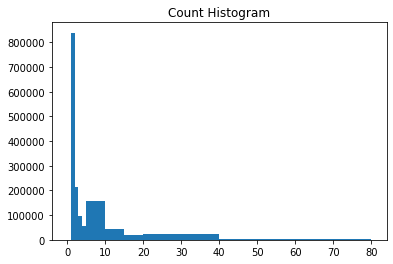

In [2]:
from matplotlib import pyplot as plt 
import numpy as np  

plt.hist(count_array,bins=[0,1,2,3,4,5,10,15,20,40,60,80]) 
  
plt.title("Count Histogram") 

In [14]:
no_features = 10

In [5]:
userToSongCount = dict()
songToUserCount = dict()

total_Entries = 0

with open('kaggle_visible_evaluation_triplets.txt','r') as f:
    for line in f:
        user, song, count = line.split()
        total_Entries += 1
        count = int(count)
        if(count>=3):
            if(count<=5):
                count = 3
            elif(count<=10):
                count = 4
            elif(count<=40):
                count = 5
            else:
                count = 6
                
        if user in userToSongCount:
            userToSongCount[user].append((song,count))
        else:
            userToSongCount[user] = [(song,count)]

        if song in songToUserCount:
            songToUserCount[song].append((user,count))
        else:
            songToUserCount[song] = [(user,count)]

songs = sorted(songToUserCount.keys())
users = sorted(userToSongCount.keys())

songsToIndex = dict()
usersToIndex = dict()

for n, song in enumerate(songs, start=0):
    songsToIndex[song] = n

for n, user in enumerate(users, start=0):
    usersToIndex[user] = n

totalSongs = len(songs)
totalUsers = len(users)

In [6]:
print("Total users:", totalUsers)
print("Total songs:", totalSongs)
print("Total entries:", total_Entries)

Total users: 110000
Total songs: 163206
Total entries: 1450933


(array([842., 773., 726., 614., 565., 432., 393., 341., 290., 221., 170.,
        151., 135.,  98.,  53.,  51.,  23.,  30.,  20.,  13.]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50]),
 <BarContainer object of 20 artists>)

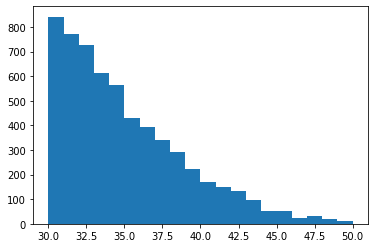

In [7]:
entry_each_user=[]

for user in userToSongCount:
    entry_each_user.append(len(userToSongCount[user]))

plt.hist(entry_each_user,bins=[30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50])

(array([298., 317., 309., 260., 275., 234., 228., 230., 194., 181., 200.,
        203., 168., 178., 153., 152., 130., 142., 131., 262.]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50]),
 <BarContainer object of 20 artists>)

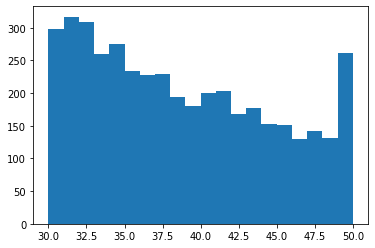

In [8]:
entry_each_song=[]

for song in songToUserCount:
    entry_each_song.append(len(songToUserCount[song]))

plt.hist(entry_each_song,bins=[30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50])

In [7]:
songEntry = {}
userEntry = {}
train_data = dict()
test_data = dict()

for user in userToSongCount:
    userEntry[user] = len(userToSongCount[user])

for song in songToUserCount:
    songEntry[song] = len(songToUserCount[song])

for user in userToSongCount:
    if(userEntry[user]>=25):
        mx=0
        for(song,count) in userToSongCount[user]:
            if(songEntry[song]>=20 and mx<5):
                mx+=1
                test_data[(user,song)] = count
                songEntry[song]-=1 
            else:
                train_data[(user,song)] = count 
    else:
        for(song,count) in userToSongCount[user]:
            train_data[(user,song)] = count

In [8]:
train_userToSongCount = dict()
train_songToUserCount = dict()

for (user,song) in train_data:
    if user in train_userToSongCount:
        train_userToSongCount[user].append((song,train_data[(user,song)]))
    else:
        train_userToSongCount[user] = [(song,train_data[(user,song)])]

    if song in train_songToUserCount:
        train_songToUserCount[song].append((user,train_data[(user,song)]))
    else:
        train_songToUserCount[song] = [(user,train_data[(user,song)])]

In [9]:
train_songs = sorted(train_songToUserCount.keys())
train_users = sorted(train_userToSongCount.keys())

print("Total users in train data:", len(train_users))
print("Total songs in train data:", len(train_songs))

Total users in train data: 110000
Total songs in train data: 163206


In [10]:
print("Length of train data:", len(train_data))
print("Length of test data:", len(test_data))

Length of train data: 1391193
Length of test data: 59740


In [11]:
song_averages = {}
user_offsets_averages = {}

# Calculate average song play count
# for given song average is sum of total play counts of that songs / number of users listened that song
for song in songs:
    song_averages[song] = sum(map(lambda x: x[1], train_songToUserCount[song])) / len(train_songToUserCount[song])


# Calculate average user offset
# Offset of given song and user = song play count for that user - average song play count of that song
# Average offset of a user = sum of offsets of all songs he/she plays / number of songs he/she plays
for user in users:
    user_offsets_averages[user] = sum(map(lambda x: (x[1] - song_averages[x[0]]), train_userToSongCount[user])) / len(train_userToSongCount[user])

# Function to calculate baseline prediction
def baseline_prediction(user, song):
    return song_averages[song] + user_offsets_averages[user]

In [47]:
# For user_feature Matrix
rows = no_features
cols = totalUsers

# Initializing user_feature matrix
user_feature = [ [ 0.1 for i in range(cols) ] for j in range(rows) ]

# For song_feature Matrix
rows = no_features
cols = totalSongs

# Initializing song_feature matrix
song_feature = [ [ 0.1 for i in range(cols) ] for j in range(rows) ]

In [18]:
LearningRate = 0.01

In [39]:
def prediction(user, song):
    predicted_count = 0
    for i in range(no_features):
        predicted_count += user_feature[i][usersToIndex[user]] * song_feature[i][songsToIndex[song]]
    return predicted_count

In [16]:
def train(user, song, count, feature_index, baseline):
    err = 0
    if(baseline):
        err = count - baseline_prediction(user, song)
    else:
        err = count - prediction(user, song)
        
    uv = user_feature[feature_index][usersToIndex[user]]
    sv = song_feature[feature_index][songsToIndex[song]]
    
    user_feature[feature_index][usersToIndex[user]] += LearningRate * err * sv
    song_feature[feature_index][songsToIndex[song]] += LearningRate * err * uv

    return err

In [51]:
for feature in range(no_features):
    err = 0

    for user in train_userToSongCount:
        for song in train_userToSongCount[user]:
            temp = abs(train(user, song[0], song[1], feature, True))
            if(temp != temp):
                print("temp ",temp)
                break
            err += temp
    
    avg_err = err / len(train_data)
    print("For feature ", feature, ": Err is = ", err, " Avg Err is = ",avg_err)

For feature  0 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  1 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  2 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  3 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  4 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  5 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  6 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  7 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  8 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  9 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902


In [19]:
interation = 0

while(interation < 20):
    print("Iteration:", interation)
    for feature in range(no_features):
        err = 0
        for user in train_userToSongCount:
            for song in train_userToSongCount[user]:
                temp = abs(train(user, song[0], song[1],feature,False))
                if(temp != temp):
                    print("temp ",temp)
                    exit()
                    break
                err += temp
        avg_err = err / len(train_data)
        print("For feature ", feature, ": Err is = ", err, " Avg Err is = ",avg_err)
        if(avg_err < 0.1):
            interation = 500
            break
    interation += 1

Iteration: 0
For feature  0 : Err is =  531627.0045624638  Avg Err is =  0.3821374924704652
For feature  1 : Err is =  529498.3151512458  Avg Err is =  0.3806073744988983
For feature  2 : Err is =  528507.512347973  Avg Err is =  0.37989517798606875
For feature  3 : Err is =  527521.223960032  Avg Err is =  0.3791862264689601
For feature  4 : Err is =  526529.4615231341  Avg Err is =  0.3784733401642577
For feature  5 : Err is =  525683.593986089  Avg Err is =  0.3778653242117298
For feature  6 : Err is =  524808.9521946257  Avg Err is =  0.37723662510854045
For feature  7 : Err is =  524065.39047907706  Avg Err is =  0.3767021473505668
For feature  8 : Err is =  523373.20178511913  Avg Err is =  0.3762045969072006
For feature  9 : Err is =  522698.0979109659  Avg Err is =  0.3757193271609086
Iteration: 1
For feature  0 : Err is =  525602.9757056828  Avg Err is =  0.3778073751849548
For feature  1 : Err is =  523509.53617172805  Avg Err is =  0.37630259509049285
For feature  2 : Err is

In [59]:
import numpy as np

np.savetxt("song_feature.txt", song_feature)
np.savetxt("user_feature.txt", user_feature)

In [2]:
import numpy as np

In [42]:
loaded_song_feature = np.loadtxt("song_feature.txt")
loaded_user_feature = np.loadtxt("user_feature.txt")

In [43]:
song_feature = loaded_song_feature
user_feature = loaded_user_feature

In [61]:
loaded_song_feature == song_feature

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [62]:
loaded_user_feature == user_feature

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [44]:
absolute_error = 0
mean_square_error = 0

for (user,song) in test_data:
    absolute_error += abs(prediction(user,song) - test_data[(user,song)])
    mean_square_error += ( (prediction(user,song) - test_data[(user,song)])**2)

absolute_error = absolute_error/len(test_data)
mean_square_error = mean_square_error/len(test_data)
rmse = (mean_square_error)**0.5

print("Average Absolute error is : ",absolute_error)
print("Root mean square error is : ",rmse)

Average Absolute error is :  1.0412638487864754
Root mean square error is :  1.431733625010405


## Condsidering the Regularization and non-Linear prediction function

In [24]:
def prediction_nonlinear(user, song):
    predicted_count = 0
    for i in range(no_features):
        predicted_count += min(user_feature[i][usersToIndex[user]] * song_feature[i][songsToIndex[song]],6)
    return min(predicted_count,6)

In [49]:
# For user_feature Matrix
rows = no_features
cols = totalUsers

# Initializing user_feature matrix
regularised_user_feature = [ [ 0.1 for i in range(cols) ] for j in range(rows) ]

# For song_feature Matrix
rows = no_features
cols = totalSongs

# Initializing song_feature matrix
regularised_song_feature = [ [ 0.1 for i in range(cols) ] for j in range(rows) ]

In [46]:
K = 0.02

In [33]:
def train_regularization(user, song, count, feature_index, baseline):
    err = 0
    if(baseline):
        err = count - baseline_prediction(user, song)
    else:
        err = count - prediction_nonlinear(user, song)
        
    uv = regularised_user_feature[feature_index][usersToIndex[user]]
    sv = regularised_song_feature[feature_index][songsToIndex[song]]
    
    regularised_user_feature[feature_index][usersToIndex[user]] += LearningRate * (err*sv - K*uv)
    regularised_song_feature[feature_index][songsToIndex[song]] += LearningRate * (err*uv - K*sv)

    return err

In [50]:
for feature in range(no_features):
    err = 0

    for user in train_userToSongCount:
        for song in train_userToSongCount[user]:
            temp = abs(train_regularization(user, song[0], song[1], feature, True))
            if(temp != temp):
                print("temp ",temp)
                break
            err += temp
    
    avg_err = err / len(train_data)
    print("For feature ", feature, ": Err is = ", err, " Avg Err is = ",avg_err)

For feature  0 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  1 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  2 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  3 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  4 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  5 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  6 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  7 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  8 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902
For feature  9 : Err is =  1004913.6334026883  Avg Err is =  0.7223394837399902


In [48]:
interation = 0

while(interation < 1):
    print("Iteration:", interation)
    for feature in range(no_features):
        err = 0
        for user in train_userToSongCount:
            for song in train_userToSongCount[user]:
                temp = abs(train_regularization(user, song[0], song[1],feature,False))
                if(temp != temp):
                    print("temp ",temp)
                    exit()
                    break
                err += temp
        avg_err = err / len(train_data)
        print("For feature ", feature, ": Err is = ", err, " Avg Err is = ",avg_err)
        if(avg_err < 0.1):
            interation = 500
            break
    interation += 1

Iteration: 0
For feature  0 : Err is =  526875.267369453  Avg Err is =  0.37872190800949473
For feature  1 : Err is =  526875.267369453  Avg Err is =  0.37872190800949473


KeyboardInterrupt: 